In [12]:
from GWAPWAi import *
import matplotlib.pyplot as plt
from torch import nn

In [13]:
#device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")

In [14]:
observ_dict = reorganize_instructions(parse_file("test_input.in"))
flat_params, unpack_fn, static_params = pack_parameters(observ_dict, wave="P")
static_params["channel_names"] = observ_dict["channels"]["names"]
exp_data = load_data(observ_dict)

In [15]:
sqrt_s_grid, values, errors, masks, channel_list, model_channel_indices = prepare_data(exp_data, static_params)
s_vals_c = (sqrt_s_grid ** 2).to(dtype=torch.cdouble)

weight_vector = torch.tensor([
    observ_dict["fitting"]["InclChi2Weight"][0] if ch == "inclusive"
    else observ_dict["fitting"]["ExclChi2Weight"][0]
    for ch in channel_list
], dtype=torch.float64, device=flat_params.device)

In [ ]:

#move everything to device and precompute the integral (THIS IS THE ONLY EXPENSIVE CELL)
for k, v in static_params.items():
    if isinstance(v, torch.Tensor):
        static_params[k] = v.to(device)
II = precompute_II(
    s_vals_c,
    static_params,
    integrate_rhoN_scp,
    rhoN_dispatcher,
    momentum,
    sheet = 0,
    epsilon = 0.003,
    num_integ = 10000
).to(device)

flat_params = randomize_initial_params(observ_dict, unpack_fn, wave="P").to(device)

/Users/wyatt/Development/GWAi-PWA/GWAPWAi/amplitude.py:256: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imag_int, imag_err = quad(lambda t: np.imag(integrand(t)),


In [17]:
model = ChiSquaredLossModule(
    initial_params=flat_params,
    unpack_fn=unpack_fn,
    static_params=static_params,
    s_vals_c=s_vals_c,
    II=II,
    values=values.to(flat_params.device),
    errors=errors.to(flat_params.device),
    masks=masks.to(flat_params.device),
    model_channel_indices=model_channel_indices.to(flat_params.device),
    weight_vector=weight_vector.to(flat_params.device),
    compute_intensity_func=compute_intensity,
    numerator_func=numerator,
    omega_pole_func=omega_pole,
    construct_phsp_func=construct_phsp,
    K_nominal_func=K_nominal,
    momentum_func=momentum
).to(device)

In [18]:
best_fit_params = run_fit(model, initial_params=flat_params)


=== Start 1/50 ===
[Adam iter   0] χ² = 53278084502.6274, max |grad| = 2.0267e+12
[Adam iter  50] χ² = 9937398.6722, max |grad| = 6.9475e+07
Final χ² after LBFGS: 51315.5580

=== Start 2/50 ===
[Adam iter   0] χ² = 5932515.7690, max |grad| = 9.3406e+07
[Adam iter  50] χ² = 2652004.8116, max |grad| = 3.3522e+06
Final χ² after LBFGS: 53030.2462

=== Start 3/50 ===
[Adam iter   0] χ² = 56756652.1347, max |grad| = 1.7885e+09
[Adam iter  50] χ² = 4097264.5015, max |grad| = 1.5372e+07
Final χ² after LBFGS: 48660.3455

=== Start 4/50 ===
[Adam iter   0] χ² = 99281543.7478, max |grad| = 2.6805e+09
[Adam iter  50] χ² = 4866145.7470, max |grad| = 1.7690e+07
Final χ² after LBFGS: 51432.9149

=== Start 5/50 ===
[Adam iter   0] χ² = 113834873302.3570, max |grad| = 7.5925e+12
[Adam iter  50] χ² = 12747549.0314, max |grad| = 2.5265e+08
Final χ² after LBFGS: 50453.6648

=== Start 6/50 ===
[Adam iter   0] χ² = 12186729.5073, max |grad| = 2.9215e+08
[Adam iter  50] χ² = 3926714.1358, max |grad| = 6.567

Total χ² (summed across all data channels): 18689.95


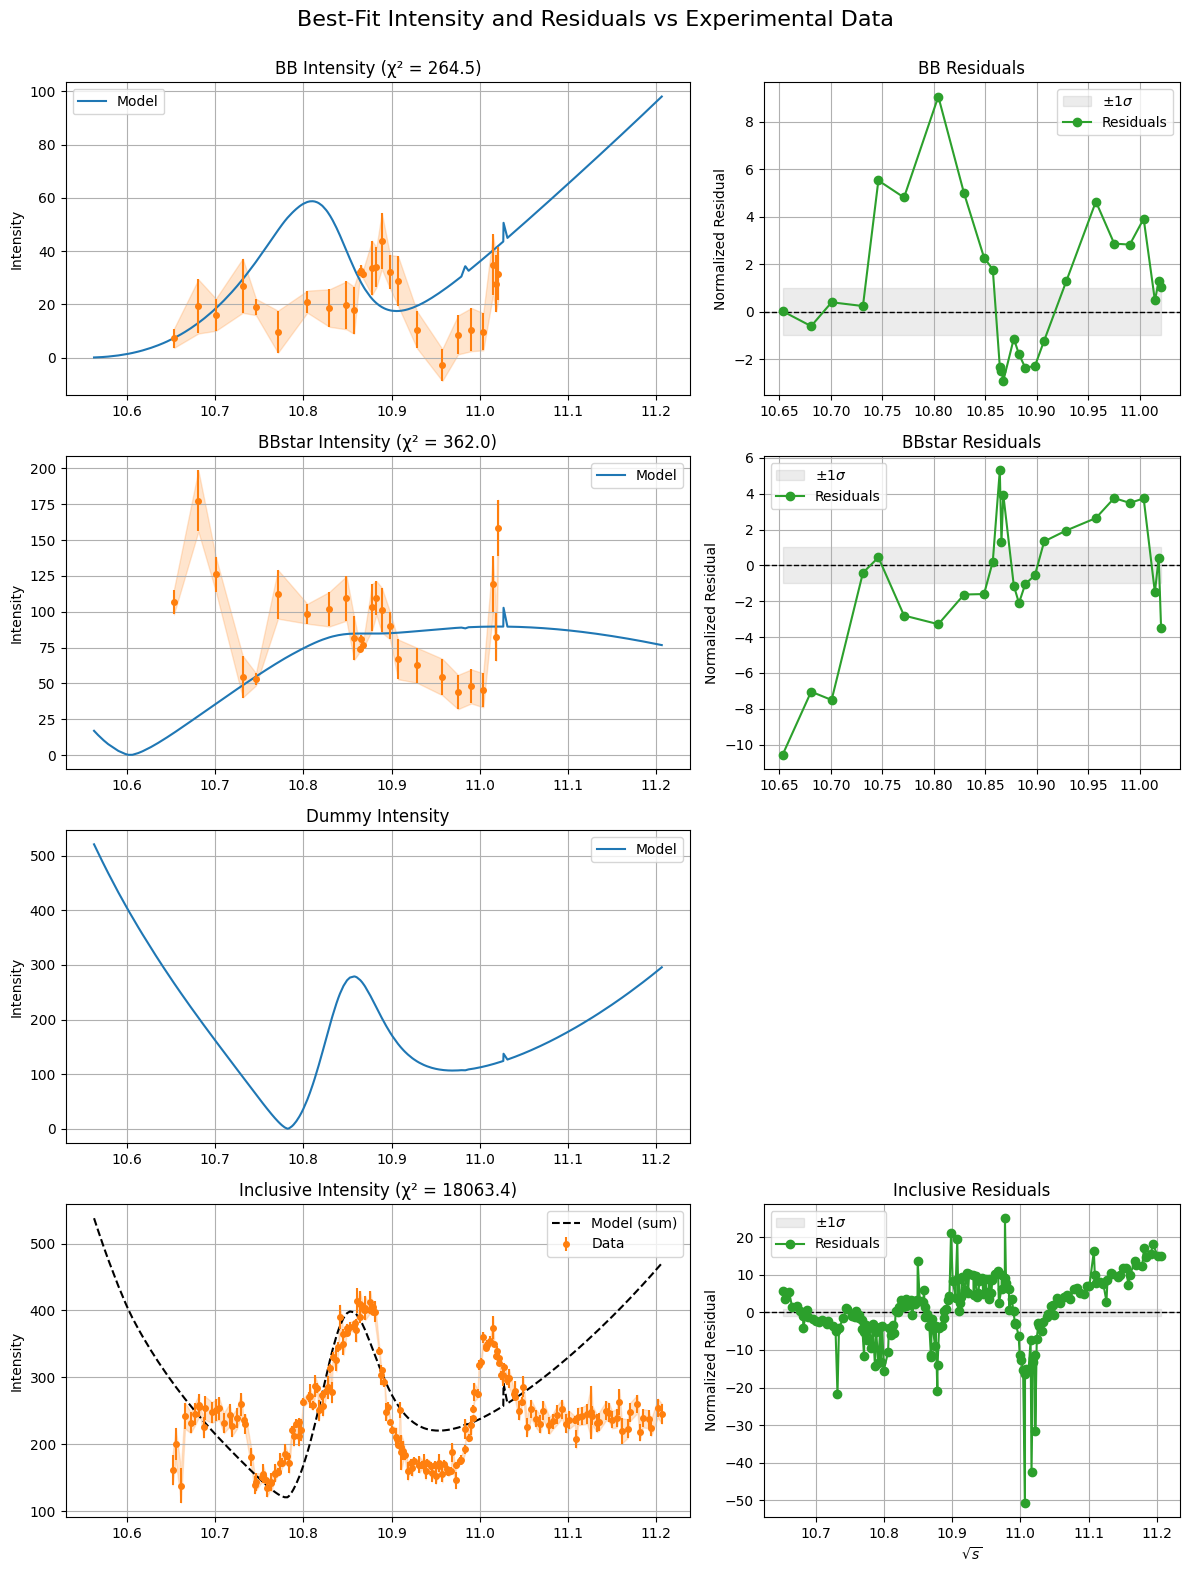

In [19]:
plot_fit_vs_data_full(
    best_fit_params=best_fit_params,
    model=model,
    sqrt_s_grid=sqrt_s_grid,
    values=values,
    errors=errors,
    masks=masks,
    channel_list=channel_list  # from prepare_exp_s_grid_and_data
)


In [20]:
updated_observ_dict = update_dict(
    observ_dict=observ_dict,
    wave="P",
    flat_params=best_fit_params,
    unpack_fn=unpack_fn
)
updated_observ_dict

{'channels': {'names': ['BB', 'BBstar', 'Dummy'],
  'masses': tensor([[5.2793, 5.2793],
          [5.2793, 5.3247],
          [5.3669, 5.4154]], dtype=torch.float64)},
 'waves': ['P'],
 'wave_data': {'P': {'kmat_type': 'kmat-nominal',
   'rhoN_type': 'rhoN-nominal',
   'J': 1,
   'sL': -81.0,
   'ChebyCoeffs': {'s': ['s = 1', 's = 1', 's = 1'],
    'coeffs': tensor([[ -46.9939, -113.8261,   -5.2497],
            [  11.3662,  -44.8281,   35.3098],
            [ -57.1280,  -72.6132,  -60.5385]], dtype=torch.float64),
    'errors': tensor([[20., 20., 20.],
            [20., 20., 20.],
            [20., 20., 20.]], dtype=torch.float64)},
   'Poles': {'mass': tensor([ 58.4319, 114.9570], dtype=torch.float64),
    'mass_err': tensor([5., 5.]),
    'couplings': tensor([[  90.3825,  -11.4434],
            [ -19.5937,  -47.6013],
            [-121.7579,   -0.9885]], dtype=torch.float64),
    'coupling_err': tensor([[20., 20.],
            [20., 20.],
            [20., 20.]], dtype=torch.float64